# Part 3. Model Building and Evaluation
-------------------------------------------------------------------------------------------------------------------

## 3. Support Vector Machine Algorithm

### 1) Data Preparation

In [73]:
#------------------------------------------------------------------------------------
# Input dataset : Case 1. 8 important features without PCA
#                 Case 2. first 2 components with PCA
#                 Case 3. first 6 components with PCA
#------------------------------------------------------------------------------------

# Import libraries and load cleansed sample dataset
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

loans_sampled = pd.read_csv("./dataset/loans_cleansed_sample.csv")
# ＠Case (1) 8 important features in the Random Forest without PCA
#        - Need to comment PCA reduction codes below
#        - Need to chanage SMOTENC() to SMOTE() below
# --------------------------------------------------------------------------------------
# loans_sampled = pd.read_csv("./dataset/loans_cleansed_sample.csv",
#                            usecols = ['recoveries', 'inq_last_6mths', 'int_rate', 
#                                       'total_pymnt', 'loan_amnt', 'dti', 'revol_util', 
#                                       'annual_inc', 'default_loan'])
loans_sampled.shape

# Next Steps: 1) Split --> 2) Scaling --> 3) SMOTE --> 4) PCA reduction

(8556, 25)

In [74]:
loans_sampled.columns
# 8 important features: recoveries, inq_last_6mths, int_rate, total_pymnt, loan_amnt, dti, revol_util, annual_inc

Index(['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'inq_last_6mths',
       'revol_util', 'total_pymnt', 'total_rec_late_fee', 'recoveries',
       'collections_12_mths_ex_med', 'default_loan', 'purpose_car',
       'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_educational', 'purpose_home_improvement', 'purpose_house',
       'purpose_major_purchase', 'purpose_medical', 'purpose_moving',
       'purpose_other', 'purpose_renewable_energy', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding'],
      dtype='object')

In [75]:
# 1) Splitting the dataset into test and train set
from sklearn.model_selection import train_test_split
y = loans_sampled['default_loan']
X = loans_sampled.drop('default_loan', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2019)

# 2) Scaling through standardisation
from sklearn.preprocessing import StandardScaler
sc = StandardScaler() # mean : 0, standard deviation : 1
sc.fit(X_train) # fit only a train dataset
X_train = sc.transform(X_train)
X_test = sc.transform(X_test) # Do not fit a test dataset

# ***************************************************************************************************
# 3) Oversampling for data that have both categorical and non-categorical attributes
# Data Imbalance - label'0' : 95%, '1' : 5%
# from imblearn.over_sampling import SMOTENC
# ***************************************************************************************************
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
# sm = SMOTENC(random_state = 2020, categorical_features = [9, 23])
sm = SMOTE(random_state = 2020)
X_train, y_train = sm.fit_sample(X_train, y_train.ravel())

# Check oversampling results
print('After Oversampling, train_X shape : {}'.format(X_train.shape))
print('After Oversampling, train_y shape : {} \n'.format(y_train.shape))

print("After Oversampling, label count '1': {}".format(sum(y_train == 1)))
print("After Oversampling, label count '0': {}".format(sum(y_train == 0)))

# 4) Dimensionality Reduction using PCA(Principal Component Analysis)
# from sklearn.decomposition import PCA
# ***************************************************************************************************
# Adjust input features in the course of model selection
# pca = PCA(n_components = 9) # Test 0.750 Explained variance ratio for first 9 - 13 componets
# pca = PCA(n_components = 2) # ＠ Case (2) the first 2 components
# pca = PCA(n_components = 6) # ＠ Case (3) the first 6 components
# ***************************************************************************************************
# X_train = pca.fit_transform(X_train)
# X_test = pca.transform(X_test)
# pca_reduction = pd.DataFrame(data = X_train)

# print(f"explained_variance = {pca.explained_variance_ratio_}") 
# print(f"pca_reduction.shape : {pca_reduction.shape}")

After Oversampling, train_X shape : (10006, 24)
After Oversampling, train_y shape : (10006,) 

After Oversampling, label count '1': 5003
After Oversampling, label count '0': 5003


### 2) Base Model Development

Working Time: 0.36520386139551797 min


----------------- Support Vector Machine Performance -----------------


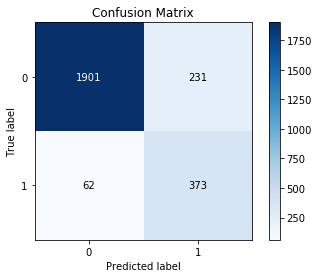

              precision    recall  f1-score   support

           0       0.97      0.89      0.93      2132
           1       0.62      0.86      0.72       435

    accuracy                           0.89      2567
   macro avg       0.79      0.87      0.82      2567
weighted avg       0.91      0.89      0.89      2567



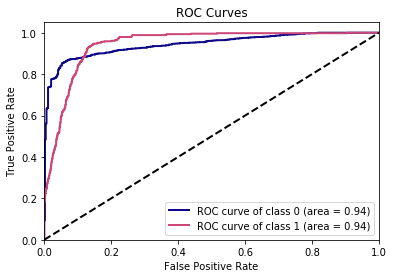

In [76]:
# Support Vector Machine base model
from sklearn import svm
import time
start_time = time.time() # Print Code Running time

# Best parameters: {'weights': 'distance', 'p': 3, 'n_neighbors': 3, 'leaf_size': 8, 'algorithm': 'auto'}
    
model = svm.SVC(probability = True)
model.fit(X_train, y_train)
prediction = model.predict(X_test)
probas = model.predict_proba(X_test) # Calculate probabilities to draw a ROC curve

# Print Code Running time
print("Working Time: {} min".format((time.time() - start_time)/60))

# Check performance of the model
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import scikitplot as skplt 

print("\n\n----------------- Support Vector Machine Performance -----------------")
skplt.metrics.plot_confusion_matrix(y_test, prediction)
plt.show()
print(classification_report(y_test, prediction))
# Draw the ROC curve
skplt.metrics.plot_roc(y_test, probas, cmap = 'plasma', plot_micro = False, plot_macro = False)
plt.show()

In [77]:
# Check hyperparameters of the base model
model.get_params()

{'C': 1.0,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'auto_deprecated',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': True,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

### 3) Model Validation

In [78]:
# k-fold cross validation
from sklearn.model_selection import cross_val_score, cross_validate
import time
start_time = time.time() # Print Code Running time

# Performance metrics : validate 'accuracy',  among: (1) roc_auc, (2) reacll, (3) f1_score (4) accuracy
metrics = ['roc_auc', 'accuracy', 'recall_weighted', 'f1_weighted']
for i in range(0, len(metrics)):
    scores = pd.DataFrame(cross_validate(model, X_train, y_train, 
                                         n_jobs = -1, 
                                         cv = 10, 
                                         scoring = metrics,
                                         return_train_score = False))
    print("[%s] average score: %.4f" % (metrics[i], scores['test_'+ metrics[i]].mean()))
    
# Print Code Running time
print("Working Time: {} min".format((time.time() - start_time)/60))

[roc_auc] average score: 0.9595
[accuracy] average score: 0.9193
[recall_weighted] average score: 0.9193
[f1_weighted] average score: 0.9192
Working Time: 3.5267498970031737 min


In [79]:
# Check scores of all performance metrics
scores.sort_values(by = 'test_roc_auc', ascending = False)

,fit_time,score_time,test_roc_auc,test_accuracy,test_recall_weighted,test_f1_weighted
3,30.951466,0.746698,0.970696,0.929000,0.929000,0.928948
5,30.498448,0.812308,0.964820,0.934000,0.934000,0.933894
6,30.967086,0.731075,0.964620,0.923000,0.923000,0.922857
2,32.104321,0.577992,0.963729,0.918164,0.918164,0.918046
4,28.951933,0.812311,0.961808,0.913000,0.913000,0.912823
9,10.552828,0.437397,0.961188,0.933000,0.933000,0.932951
7,29.139390,1.234085,0.960404,0.921000,0.921000,0.920867
0,27.108617,0.999768,0.956454,0.918164,0.918164,0.918152
8,11.802535,0.484258,0.953124,0.924000,0.924000,0.923810
1,29.717381,1.031011,0.938012,0.879242,0.879242,0.879166


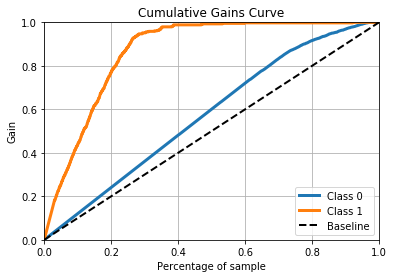

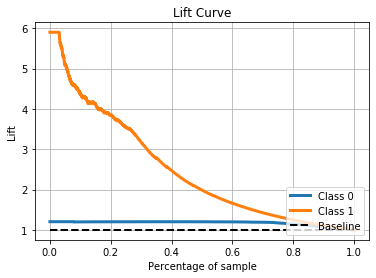

In [80]:
# Learning Curve validation
# skplt.estimators.plot_learning_curve(model, X_train, y_train, cv = 5)
skplt.metrics.plot_cumulative_gain(y_test, probas)
skplt.metrics.plot_lift_curve(y_test, probas)
# plt.show()

[Interpretation]
<ul>
    <li>The graph shows reasonably proper deviation-variance trade-off.</li>
    <li>It seems neither overfitting nor underfitting.</li>
</ul>

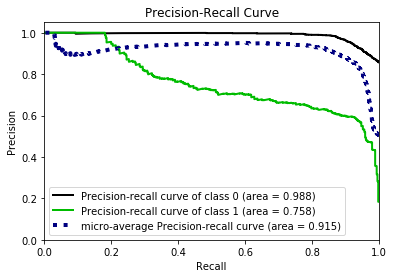

In [81]:
# Precision-Recall Curve validation
skplt.metrics.plot_precision_recall(y_test, probas)
plt.show()

[Interpretation]
<ul>
    <li>Micro-average P-R curve shows as appropirate but class 1 curve area is quite low.</li>
    <li>The balance between Recall and Precision can be made it by improving Precision of class 1.</li>
</ul>

### 4) Hyperparameter Tuning and Model Selection

 ### 4-1. Randomised Search Application

Best score : 0.9727
Best parameters: {'kernel': 'rbf', 'C': 12}
Working Time: 14.444727253913879 min


----------------- Support Vector Machine Performance -----------------


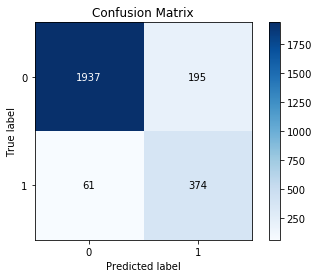

              precision    recall  f1-score   support

           0       0.97      0.91      0.94      2132
           1       0.66      0.86      0.75       435

    accuracy                           0.90      2567
   macro avg       0.81      0.88      0.84      2567
weighted avg       0.92      0.90      0.91      2567



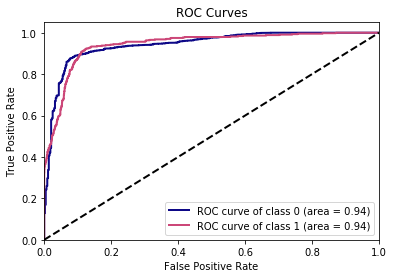

In [82]:
# Randomised Search for Hyperparameter Tuning
# Even faster than Grid Search or Nested CV
from sklearn.model_selection import RandomizedSearchCV
import time
start_time = time.time() # Print Code Running time

# Hyperparameters Set
# param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
# parameters = {'C': param_range, 'gamma': param_range, 'kernel': ['rbf']}

parameters = {'C': [6,7,8,9,10,11,12], 
              'kernel': ['linear','rbf']}

# Run randomized search
n_iteration = 20
rs = RandomizedSearchCV(model, 
                        param_distributions = parameters,
                        n_iter = n_iteration,
                        scoring = 'roc_auc', # Change metrics
                        cv = 5)
rs.fit(X_train, y_train)

result = pd.DataFrame(rs.cv_results_['params'])
result['mean_test_score'] = rs.cv_results_['mean_test_score']
result.sort_values(by = 'mean_test_score', ascending = False)

# Check best parameters
print("Best score : %0.4f" % rs.best_score_)
print(f"Best parameters: {rs.best_params_}")

# Tuned Model construction
model = rs.best_estimator_
model.fit(X_train, y_train)
prediction = model.predict(X_test)
probas = model.predict_proba(X_test)

# Save the model to disk using Pickle
import pickle

filename = './models/final_Model_SVM.sav'
pickle.dump(model, open(filename, 'wb'))

# Check performance of the model
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import scikitplot as skplt 

# Print Code Running time
print("Working Time: {} min".format((time.time()-start_time)/60))

print("\n\n----------------- Support Vector Machine Performance -----------------")
skplt.metrics.plot_confusion_matrix(y_test, prediction)
plt.show()
print(classification_report(y_test, prediction))
# Draw the ROC curve
skplt.metrics.plot_roc(y_test, probas, cmap = 'plasma', plot_micro = False, plot_macro = False)
plt.show()

[Interpretation]
<ul>
    <li>There is a very slight <b><u>no difference between a base model and a tuned one.</b></u></li>
    <li>Performance improvement expectations : 1 - 2 % point of increase</li>
</ul>

### 4-2. Grid Search Application

Best score : 0.9727
Best parameters: {'C': 12, 'kernel': 'rbf'}
Working Time: 4.951009555657705 min


----------------- Support Vector Machine Performance -----------------


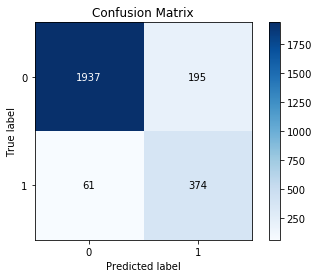

              precision    recall  f1-score   support

           0       0.97      0.91      0.94      2132
           1       0.66      0.86      0.75       435

    accuracy                           0.90      2567
   macro avg       0.81      0.88      0.84      2567
weighted avg       0.92      0.90      0.91      2567



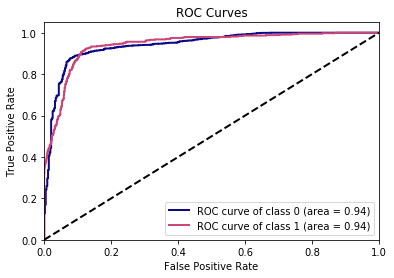

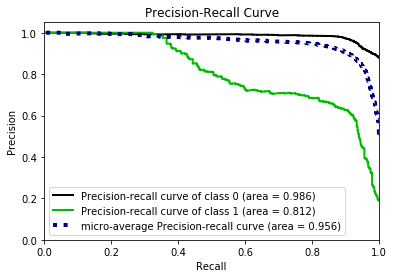

In [83]:
# Grid Search for hyperparameter tuning
from sklearn.model_selection import GridSearchCV
import time
start_time = time.time() # Print Code Running time

# Hyperparameters Set
# param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
# parameters = {'C': param_range, 'gamma': param_range, 'kernel': ['rbf']}

parameters = {'C': [6,7,8,9,10,11,12], 
              'kernel': ['linear','rbf']}

# Focus on 'recall' and 'roc_auc' metrics due to computational complexity
# Sensitiviy is far more important to predict loan defalult than others.
# This requires high level of computing power
gs = GridSearchCV(model, 
                  param_grid = parameters, 
                  scoring = 'roc_auc',
                  n_jobs = -1, 
                  cv = 5)
gs.fit(X_train, y_train)

result = pd.DataFrame(gs.cv_results_['params'])
result['mean_test_score'] = gs.cv_results_['mean_test_score']
result.sort_values(by = 'mean_test_score', ascending = False)

# Check best parameters
print("Best score : %0.4f" % gs.best_score_)
print(f"Best parameters: {gs.best_params_}")

# Tuned Model construction
model = gs.best_estimator_
model.fit(X_train, y_train)
prediction = model.predict(X_test)
probas = model.predict_proba(X_test)

# Check performance of the model
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import scikitplot as skplt 

# Print Code Running time
print("Working Time: {} min".format((time.time() - start_time)/60))

print("\n\n----------------- Support Vector Machine Performance -----------------")
skplt.metrics.plot_confusion_matrix(y_test, prediction)
plt.show()
print(classification_report(y_test, prediction))

# Draw the ROC curve
skplt.metrics.plot_roc(y_test, probas, cmap = 'plasma', plot_micro = False, plot_macro = False)
plt.show()

# Precision-Recall Curve validation
skplt.metrics.plot_precision_recall(y_test, probas)
plt.show()

### 4-3. Nested Cross Validation with Grid Search

CV Accuracy: 0.973 +/- 0.005
 CV Scores: [0.96264475 0.97584234 0.97811579 0.974103   0.972758  ]
Best Score: 0.9694839845064037
Best Parameters: {'C': 12, 'kernel': 'rbf'}
Working Time: 3.1002848426500957 min


----------------- Support Vector Machine Performance -----------------


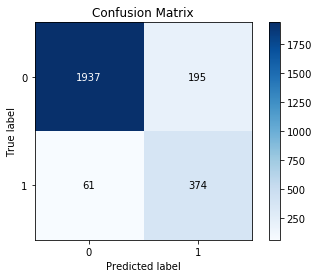

              precision    recall  f1-score   support

           0       0.97      0.91      0.94      2132
           1       0.66      0.86      0.75       435

    accuracy                           0.90      2567
   macro avg       0.81      0.88      0.84      2567
weighted avg       0.92      0.90      0.91      2567



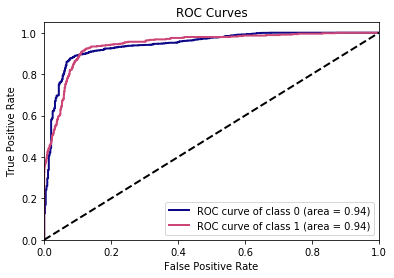

In [84]:
# Nested Cross Validation : 5*2 Cross Validation
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score, auc, f1_score, accuracy_score
import time
start_time = time.time() # Print Code Running time

# Hyperparameters Set
# param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
# parameters = {'C': param_range, 'gamma': param_range, 'kernel': ['rbf']}

parameters = {'C': [6,7,8,9,10,11,12], 
              'kernel': ['linear','rbf']}

# Scoring
nested_gs = GridSearchCV(model, 
                         param_grid = parameters, 
                         scoring = 'roc_auc',
                         n_jobs = -1, 
                         cv = 2)
scores = cross_val_score(nested_gs, 
                         X_train, 
                         y_train, 
                         scoring = 'roc_auc',
                         n_jobs = -1, 
                         cv = 5)

print("CV Accuracy: %.3f +/- %.3f" % (np.mean(scores), np.std(scores)))
print(f" CV Scores: {scores}")

model = nested_gs.fit(X_train, y_train)
print(f"Best Score: {nested_gs.best_score_}")
print(f"Best Parameters: {nested_gs.best_params_}")

model = nested_gs.best_estimator_
model.fit(X_train, y_train)
prediction = model.predict(X_test)
probas = model.predict_proba(X_test)

# Print Code Running time
print("Working Time: {} min".format((time.time() - start_time)/60))

print("\n\n----------------- Support Vector Machine Performance -----------------")
skplt.metrics.plot_confusion_matrix(y_test, prediction)
plt.show()
print(classification_report(y_test, prediction))
# Draw the ROC curve
skplt.metrics.plot_roc(y_test, probas, cmap = 'plasma', plot_micro = False, plot_macro = False)
plt.show()